In [4]:
import os
import json

def get_data(folder_name):
    x = []
    y = []
    positions = []
    file_names = []

    for file in os.listdir(folder_name):
        if file.endswith(".txt"):
            file_name = os.path.join(folder_name, file[:-4])

            file_text = open(file_name + '.txt', encoding='utf8')
            try:
                file_truth = open(file_name + '.truth', encoding='utf8')

                try:
                    text = file_text.read()
                    truth = json.load(file_truth)
                    truth_changes = truth['changes']
                    truth_positions = truth['positions']

                    x.append(text)
                    y.append(truth_changes)
                    positions.append(truth_positions)
                    file_names.append(file[:-4])
                finally:
                    file_truth.close()
            finally:
                file_text.close()

    return x, y, positions, file_names

In [8]:
import numpy as np
TRAINING_DIR = '../../data/training'

X, y, positions, file_names = get_data(
    TRAINING_DIR)
X=np.array(X)
y=np.array(y)

In [9]:
print(X.shape, y.shape)

(2980,) (2980,)


In [43]:
params = {
            'model_description' : 'LightGBM with Logistic Regression',
            'lighgbm' : {
                'learning_rate': 0.1,
                'application': 'binary',
                'num_leaves': 31,
                'verbosity': -1,
                'metric': 'auc', # All our validation and calculation metrics are in terms of Accuracy ! I am adding another point of view with 'auc' for additional monitoring
                'data_random_seed': 2,
                'bagging_fraction': 0.8,
                'feature_fraction': 0.6,
                'nthread': 4,
                'lambda_l1': 1,
                'lambda_l2': 1,
                'min_data_in_leaf' : 40,
            },
            'logistic_regression' : {
                'inverse_strength' : 2.0,
                'solver' : 'sag',
                'minimum_feature_weight' : 0.3,
            },
            'optimal_rounds' : {
                'is_multi_author' : 140,
            },
            'num_folds' : 5,
            'cv_random_seed' : 777,
            'max_features' : 30000
}

In [44]:
from nltk.tokenize import word_tokenize
import numpy as np
import math

def split_seq(seq, depth, breath=None):
    if not breath:
        breath = round(len(seq) / depth)
    newseq = []
    splitsize = (1.0/breath)*len(seq)
    for i in range(breath):
        newseq.append(' '.join(seq[round(i*splitsize):round((i+1)*splitsize)]))
    return newseq

def get_segments(text, n, chunks, wordFilter=None, process=False):
    words = word_tokenize(text)
    segments = split_seq(words, n, chunks)
    if wordFilter:
        segments = [wordFilter(s) for s in segments]
    return segments

def get_sliding_words(text, n=None, chunks=None, wordFilter=None, process=False):
    segments = []
    words = word_tokenize(text)

    mult = 3
    if n:
        n = min(n, len(words))
        chunks = round(len(words) / n)
    
    parts = chunks * mult
    part_size = round(len(words) / parts)
    i = 0
    for i in range(0, parts - mult):
        segments.append(' '.join(words[i*part_size:i*part_size+mult*part_size]))
    segments.append(' '.join(words[i*part_size:]))
    
    if wordFilter:
        segments = [wordFilter(s) for s in segments]
    
    return segments

def word_chunks(X, n=None, chunks=None, wordFilter=None, sliding=False, process=False):
    chunker = get_sliding_words if sliding else get_segments
    
    return np.array([chunker(text, n, chunks, wordFilter, process) for text in X])

In [45]:
X_word_chunks = word_chunks(X, chunks=3)

In [46]:
np.array(X_word_chunks).shape

(2980, 3)

In [47]:
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    max_features=params['max_features']
)

word_vectorizer.fit(X)

# char_vectorizer = TfidfVectorizer(
#     sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='char',
#     stop_words='english',
#     ngram_range=(2, 6),
#     max_features=params['max_features']
# )

# char_vectorizer.fit(X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [94]:
from keras.preprocessing.text import Tokenizer
num_words = 100000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X)

In [95]:
from keras.preprocessing.sequence import pad_sequences
def to_seq(X):
    transformed = []
    for i, doc in enumerate(X):
        train_word_features = tokenizer.texts_to_sequences(doc)
        transformed.append(pad_sequences(train_word_features, maxlen=num_words))
    return transformed

In [96]:
X_transformed = np.array(to_seq(X_word_chunks))

MemoryError: 

In [ ]:
X_transformed.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
X_train.shape

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, MaxPooling1D
from keras.layers import AveragePooling1D, GlobalAveragePooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam, SGD
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
epochs = 15
batch_size = 64
input_shape = (X_train.shape[1], X_train.shape[2])

In [ ]:
def get_model():
    model = Sequential()
    model.add(LSTM(128, dropout=0.2, return_sequences = False, input_shape=input_shape))
    #model.add(LSTM(128, dropout=0.2, return_sequences = False))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
                    #, kernel_regularizer=regularizers.l2(0.001)))
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    sgd = SGD(lr=0.01, momentum=0.01, decay=0.0001, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
model = get_model()
model.summary()

In [ ]:
model = get_model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    #callbacks=get_callbacks(), 
                    epochs=epochs, batch_size=batch_size)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [118]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, y):
  # create model
    model = get_model()
    # Fit the model
    history = model.fit(X[train], y[train], 
                        #callbacks=get_callbacks(), 
                        epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

acc: 65.28%
acc: 65.01%
acc: 62.77%
acc: 63.31%
64.09% (+/- 1.08%)


In [ ]:
64.90% (+/- 1.08%)

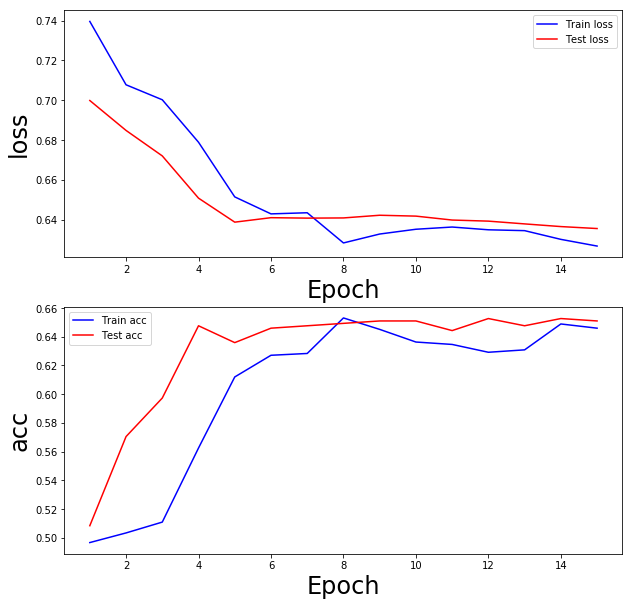

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))

def plot_history(ax, history, metric):
    rng = list(range(1, epochs + 1))
    m, = ax.plot(rng, history[metric], 'b', label='Train ' + metric)
    val_m, = ax.plot(rng, history['val_' + metric], 'r', label='Test ' + metric)
    ax.legend(handles=[m, val_m])
  
  
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel(metric, fontsize=24)  

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

plot_history(ax1, history.history, 'loss')
plot_history(ax2, history.history, 'acc')